<a href="https://colab.research.google.com/github/victor-s-salles/AlexNet-VGG16/blob/main/Hymenoptera.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Classificação binária dataset Hymenoptera

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.optimizers import SGD, Adam
import numpy as np
import matplotlib.pyplot as plt
import pathlib
from matplotlib.ticker import MaxNLocator
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import gc
import cv2
import PIL
from PIL import Image, ImageOps
import pandas as pd
from pandas.plotting import table



##Carregamento e processamento do dataset Hymenoptera
Consistem em imagens de abelhas (bees) e formigas (ants)


In [ ]:
base_dir = '/content/drive/MyDrive/ColabFiles/trabalho/hymenoptera'
#base_dir='/content/drive/MyDrive/hymenoptera/hymenoptera'
class_names=['ant','bee']
def load_dataset(directory,mode, img_size, aug=False):
  data = tf.keras.utils.image_dataset_from_directory(
  directory=directory,
  labels="inferred",
  label_mode=mode,
  class_names=None,
  color_mode="rgb",
  image_size=img_size,
  shuffle=True,
  seed=None,
  validation_split=None,
  subset=None,
  interpolation="bilinear",
  follow_links=False,
  batch_size=None,
  crop_to_aspect_ratio=False,
  )
  return process_dataset(data,aug)

def process_dataset(dataset,aug):
  images = []
  labels = []
  for image, label in dataset:
    image = image.numpy()
    images.append(image)
    labels.append(label)
    if aug == True:
      height, width = image.shape[:2]
      scale = 4
      resized = cv2_clipped_zoom(image,scale)
     # print(f'resized type {type(resized)}')
      images.append(cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE))
      images.append(cv2.rotate(image, cv2.ROTATE_180))
      images.append(resized)
      labels.append(label)
      labels.append(label)
      labels.append(label)
  images = np.array(images)/255.0
  labels= np.array(labels)
  return images, labels

def show_binary_dataset(images,labels,mode, class_names = ['ants','bees'], title=''):
    plt.figure(figsize=(10,10))
    for i in range(10):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        if mode == "binary":
          plt.xlabel(class_names[int((labels[i] == True))])
        else:
          plt.xlabel(class_names[int(not(labels[i][0] == True))])
    plt.show()

def cv2_clipped_zoom(img, zoom_factor=0):

    """
    Center zoom in/out of the given image and returning an enlarged/shrinked view of
    the image without changing dimensions
    ------
    Args:
        img : ndarray
            Image array
        zoom_factor : float
            amount of zoom as a ratio [0 to Inf). Default 0.
    ------
    Returns:
        result: ndarray
           numpy ndarray of the same shape of the input img zoomed by the specified factor.
    """
    if zoom_factor == 0:
        return img


    height, width = img.shape[:2] # It's also the final desired shape
    new_height, new_width = int(height * zoom_factor), int(width * zoom_factor)

    ### Crop only the part that will remain in the result (more efficient)
    # Centered bbox of the final desired size in resized (larger/smaller) image coordinates
    y1, x1 = max(0, new_height - height) // 2, max(0, new_width - width) // 2
    y2, x2 = y1 + height, x1 + width
    bbox = np.array([y1,x1,y2,x2])
    # Map back to original image coordinates
    bbox = (bbox / zoom_factor).astype(np.int)
    y1, x1, y2, x2 = bbox
    cropped_img = img[y1:y2, x1:x2]

    # Handle padding when downscaling
    resize_height, resize_width = min(new_height, height), min(new_width, width)
    pad_height1, pad_width1 = (height - resize_height) // 2, (width - resize_width) //2
    pad_height2, pad_width2 = (height - resize_height) - pad_height1, (width - resize_width) - pad_width1
    pad_spec = [(pad_height1, pad_height2), (pad_width1, pad_width2)] + [(0,0)] * (img.ndim - 2)

    result = cv2.resize(cropped_img, (resize_width, resize_height))
    result = np.pad(result, pad_spec, mode='constant')
    assert result.shape[0] == height and result.shape[1] == width
    return result


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Extração de métricas

* Acurácia
* Perda
* Matriz de confusão

###Para dataset binário
* Accuracy.
* Precision and recall.
* F1 score.



In [ ]:

#Função para salvar os gráficos
def save_fig(figure, filename, formats,folder='graficos'):
  # print(filename)
  for format in formats:
     figure.savefig("/content/drive/MyDrive/trab-visao/{}/{}.{}".format(folder,filename, format), format=format, dpi=100)
     #figure.savefig("/content/drive/MyDrive/hymenoptera/{}/{}.{}".format(folder,filename, format), format=format, dpi=100)



# Função para plotar acurácia e perda
def plot_history(history, metrics,title=''):
    print(f'titulo: {title}')
    fig = plt.figure(figsize=(12, 5))
    plt.suptitle(title)
    # Plotar Acurácia
    plt.subplot(1, 2, 1)
    plt.plot(history.history[ list(metrics.items())[1][0]], label='Training Accuracy')
    plt.plot(history.history[f'val_{list(metrics.items())[1][0]}'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plotar Perda
    plt.subplot(1, 2, 2)
    plt.plot(history.history[ list(metrics.items())[0][0]], label='Training Loss')
    plt.plot(history.history[ f'val_{list(metrics.items())[0][0]}'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    title_plt1 =  f'acc loss {title}'
    save_fig(fig,title_plt1.replace('.',''),['svg','jpg'])

    fig2 = plt.figure(figsize=(16, 5))
    plt.suptitle(title)
    #Plotar Precisão
    plt.subplot(1, 3, 1)
    plt.plot(history.history[ list(metrics.items())[2][0]], label='Training Precision')
    plt.plot(history.history[ f'val_{list(metrics.items())[2][0]}'], label='Validation Precision')
    plt.title('Training and Validation Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.legend()

    #Plotar Recall
    plt.subplot(1, 3, 2)
    plt.plot(history.history[ list(metrics.items())[3][0]], label='Training Recall')
    plt.plot(history.history[ f'val_{list(metrics.items())[3][0]}'], label='Validation Recall')
    plt.title('Training and Validation Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.legend()


    #Plota f1 score
    plt.subplot(1, 3, 3)
    train_f1_scores = []
    val_f1_scores = []

    for tp, tr in zip(history.history[f'val_{list(metrics.items())[2][0]}'],history.history[f'val_{list(metrics.items())[3][0]}'] ):
        train_f1_scores.append(f1_score(tp,tr))
    for vp, vr in zip(history.history[f'val_{list(metrics.items())[2][0]}'],history.history[f'val_{list(metrics.items())[3][0]}'] ):
        val_f1_scores.append(f1_score(vp,vr))

    plt.plot(train_f1_scores, label='Training F1-Score')
    plt.plot(val_f1_scores, label='Validation f1-Score')
    plt.title('Training and Validation F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()
    title_plt2 =  f'pre rec {title}'
    save_fig(fig2,title_plt2.replace('.',''),['svg','jpg'])


# Função para plotar a matriz de confusão para modelo de classes
def plot_confusion_matrix(model, x_test, y_test,title=''):
    predictions = model.predict(x_test)
    y_pred = np.argmax(predictions, axis=1)
    y_true = np.argmax(y_test, axis=1)
    cm = confusion_matrix(y_true, y_pred)

    fig = plt.figure(figsize=(12, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{title} - Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()
    save_fig(fig,title,['jpg','svg'])


# Função para plotar a matriz de confusão para modelo binários
def plot_binary_confusion_matrix(model, x_test, y_test, threshold, title=''):
    predictions = model.predict(x_test)
    #print(f'{threshold}')
    binary_predictions = ((predictions) > threshold).astype(int)
    #print(binary_predictions)

    y_pred = np.array(binary_predictions)
    y_true = np.array(y_test)
    #print(y_true)
    cm = confusion_matrix(y_true, y_pred)

    fig = plt.figure(figsize=(12, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{title} - Binary Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()
    save_fig(fig,title,['jpg','svg'])
    #save_plot(fig,title.replace(" ", "-"),['jpg','svg'])

#Função para plotar tabela com os dados do teste no conjunto de dados de teste
def plot_table(data,collabels, title):
  mydataset = {
  'loss': data[0],
  'acuracy': data[1],
  'precision':data[2],
  'recall':data[3],
  'f1 score': f1_score(data[2],data[3])
}
  df = pd.DataFrame(mydataset, index=[0])

  fig, ax = plt.subplots(figsize=(15, 3)) # set size frame
  ax.xaxis.set_visible(False)  # hide the x axis
  ax.yaxis.set_visible(False)  # hide the y axis
  ax.set_frame_on(False)  # no visible frame, uncomment if size is ok
  tabla = table(ax, df, loc='center', colWidths=[0.25]*len(df.columns))  # where df is your data frame
  tabla.auto_set_font_size(False) # Activate set fontsize manually
  tabla.set_fontsize(12) # if ++fontsize is necessary ++colWidths
  tabla.scale(1.2, 1.2) # change size table
  plt.figtext(0.5, 0.01, title, ha="center", fontsize=18)
  plt.title('Model Test Results (Test data)')

  #ax.table(cellText=[np.array(data)],colLabels=collabels,loc='center')
  plt.show()
  #ax.table(cellText=celltext,colLabels=collabels,loc='center')
  save_fig(fig,title,['jpg','svg'],'tabelas')

def f1_score(precision, recall):
  if (round((precision+recall),4)<=0.0000):
    return
  return ((precision*recall)/(precision+recall))



Com essas alterações podemos observar que a função de ativação fez diferença, com o modelo tendo uma base sólida é possível fazer as mudanças de hiperparametros como taxa de aprednizado, otimizador entre outras.

O Keras tem uma funcionalidade interessante que viabiliza o ajuste da learning rate de forma automática e nos permite visualizar suas alterações durante um períodod de treinamento.

Há diversos otimizadores como (citar) o que pareceu interessante para o nosso caso foi o (nome) porque (explica)

##Carregamento dataset em diferentes modos



In [ ]:
mode = "categorical"
scale=4
img_size = (224,224)
aug=True

In [ ]:
train_images, train_labels = load_dataset(base_dir+'/train',mode,img_size, aug=aug)
test_images, test_labels = load_dataset(base_dir+'/val',mode,img_size)


Found 244 files belonging to 2 classes.


<ipython-input-2-fa14a0f8f106>:88: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bbox = (bbox / zoom_factor).astype(np.int)


Found 153 files belonging to 2 classes.


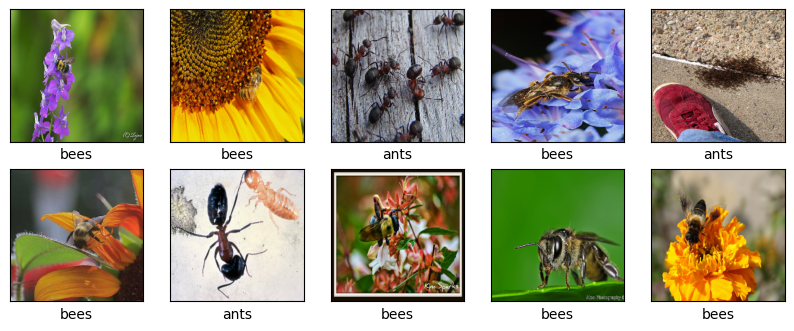

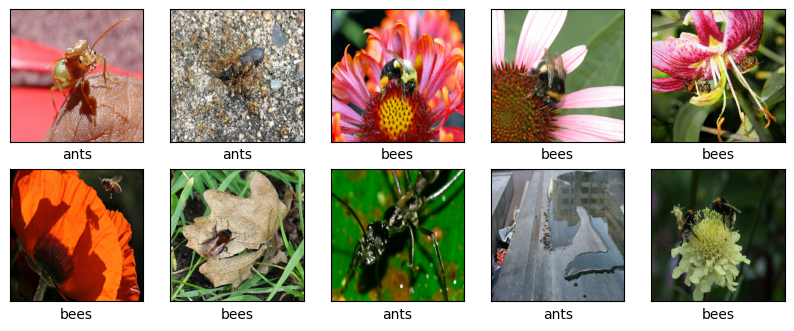

In [ ]:
show_binary_dataset(train_images,train_labels,mode,title='train images')
show_binary_dataset(test_images,test_labels,mode, title= 'test images')

#AlexNet

##Iplementação

In [ ]:
def create_alexnet(num_classes,input_shape, last_activation):
    return Sequential([
              Conv2D(96, 11, activation='relu', strides=4, input_shape=input_shape),
              MaxPooling2D(3,2),
              Conv2D(256,5,activation='relu',padding='same'),
              MaxPooling2D(3,2),
              Conv2D(384,3,activation='relu',padding='same'),
              Conv2D(384,3,activation='relu',padding='same'),
              Conv2D(256,3,activation='relu',padding='same'),
              Flatten(),
              Dense(4096, activation='relu'),
              Dropout(0.5),
              Dense(4096, activation='relu'),
              Dropout(0.5),
              Dense(num_classes, activation=last_activation)]
            )


###Primeira compilação
Tratamento do dataset no modo de categorias cada entrada terá duas classes sendo uma preenchida com valor positivo e a outra negativo. Arquitetura original da rede AlexNet com 2 outputs um para cada classe. Performance inicial é satisfatória

###Segunda compilação AlexNet
Tratamento do dataset no modo binário cada entrada tem apenas um valor de positivo ou negativo para uma classe. Arquitetura original da AlexNet com output de 1 de 1 classe.A função softmax na camada de saída dá apenas a probabilidade da entrada pertencer a uma única classe a performance inicial tem acurácia praticamente inalterável a depender da taxa de aprendizado e exige mais dos outros hiperparametros.






###Terceira compilação AlexNet
Tratamento do dataset no modo binário. Arquitetura da AlexNet com output de 1 de 1 classe e função de ativação sigmoid que informa o quanto a predição é próxima de uma das duas classes, 0 ou 1.





##Compilação e treinamento AlexNet



In [ ]:
input_shape = (224,224,3)
epochs=30
batch_size=256
learning_rate= 0.00001
threshold = 0.5
activation = 'softmax'
loss_functions = {'categorical':tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                'binary':tf.keras.losses.BinaryCrossentropy(from_logits=False)}
title = f"AlexNet {mode} af:{activation} img size {img_size} aug={'yes' if aug==True else 'no'}{epochs} epochs batch {batch_size} LR {learning_rate}"


In [ ]:
alexnet = create_alexnet(2, input_shape,activation)


In [ ]:
tf.keras.backend.clear_session()

del alexnet

In [ ]:
alexnet.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss=loss_functions[mode],
                  metrics=[
                      'accuracy',
                      tf.keras.metrics.Precision(),
                      tf.keras.metrics.Recall(),
                      ])
history_alexnet= alexnet.fit(train_images, train_labels, batch_size=batch_size, epochs=epochs,validation_split=0.2)


Epoch 1/30


ResourceExhaustedError: ignored

2/2 [==============================] - 0s 34ms/step - loss: 3.2028 - accuracy: 0.5752 - precision: 0.5752 - recall: 0.5752


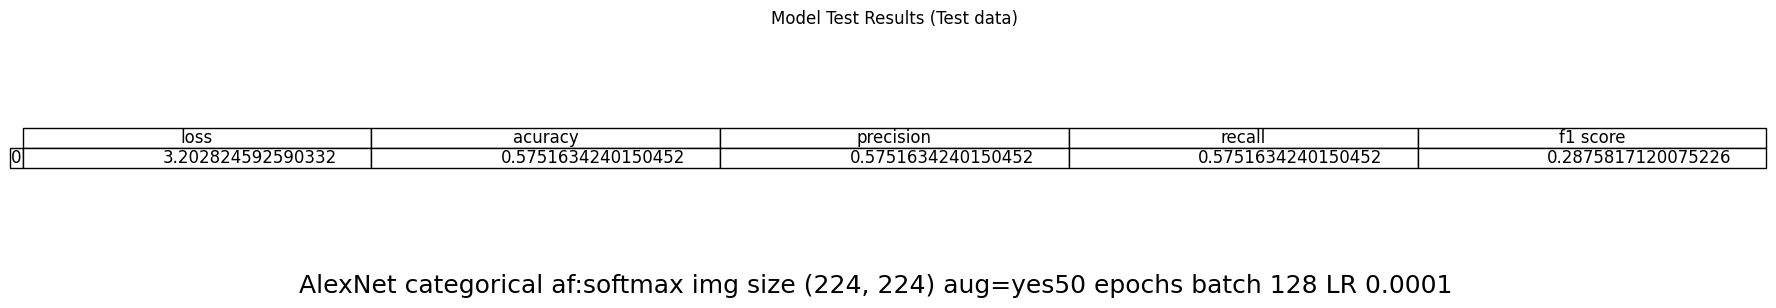

titulo: AlexNet categorical af:softmax img size (224, 224) aug=yes50 epochs batch 128 LR 0.0001
5/5 [==============================] - 0s 26ms/step


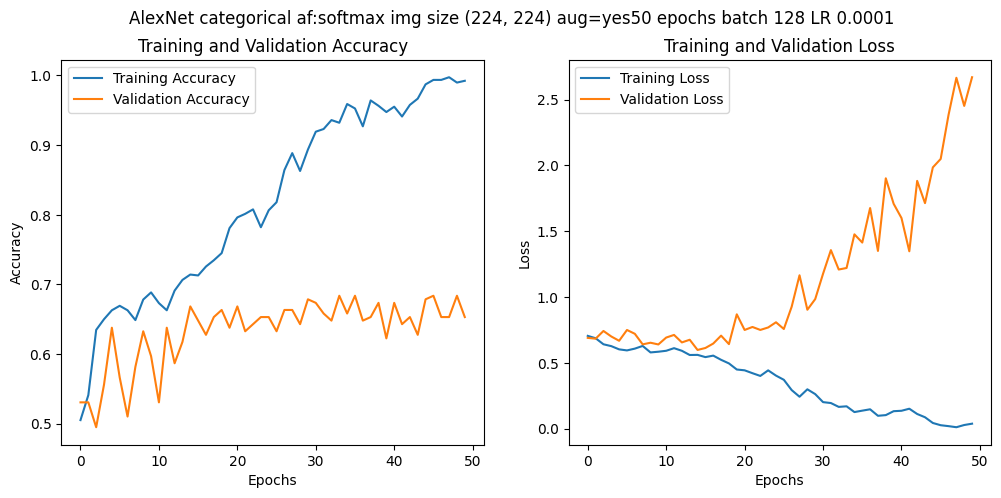

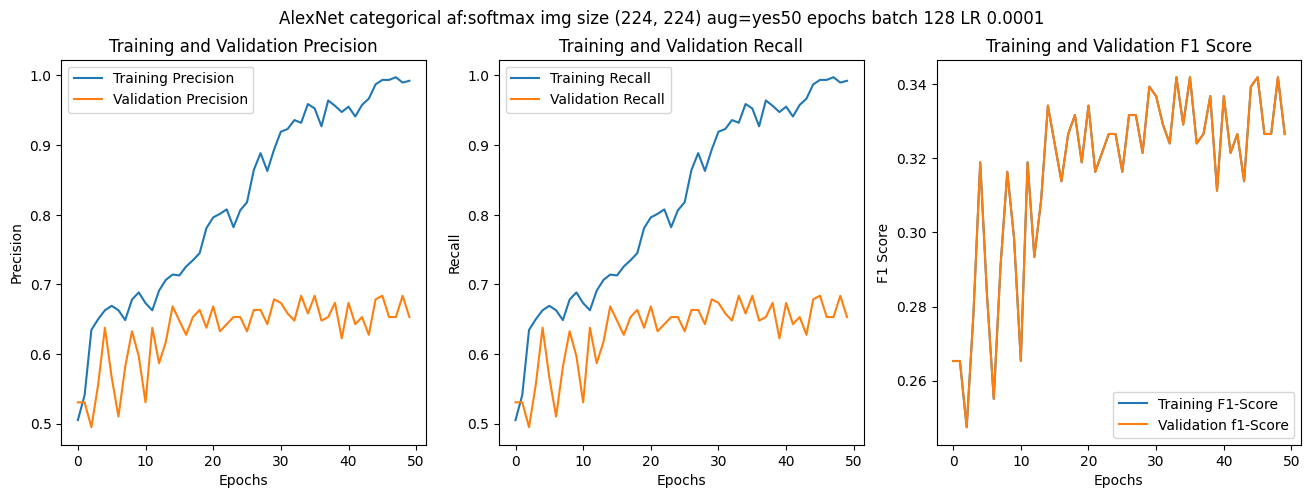

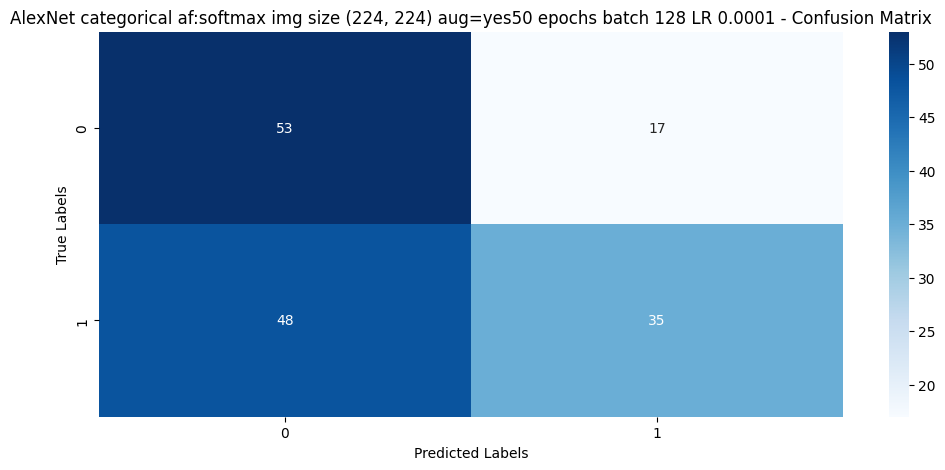

In [ ]:
result = alexnet.evaluate(test_images,  test_labels, batch_size=batch_size, verbose=1)
plot_table(result,alexnet.metrics_names,title)
metrics = alexnet.get_metrics_result()
plot_history(history_alexnet, metrics,title)
if mode == 'binary':
  plot_binary_confusion_matrix(alexnet, test_images, test_labels, threshold, title)
else:
  plot_confusion_matrix(alexnet, test_images, test_labels, title)


In [ ]:
list(metrics.items())[1][0]

'loss'

'precision_1'

#VGG16

Fonte: https://becominghuman.ai/transfer-learning-part-4-0-vgg-16-and-vgg-19-d7f0045032de


##Implementação

In [ ]:
def create_vgg16(num_classes,input_shape,last_activation='softmax'):
    return Sequential([
            #2 Convolutions with 3x3 kernel : 224x224x64. Image: 224x224x3
            Conv2D(64, 3, activation='relu', padding="same", input_shape=input_shape),
            Conv2D(64, 3, activation='relu', padding="same"),
            #Pool with 2x2 max kernel+2 stride:112x112x64
            MaxPooling2D(2,2),
            #2 Convolutions with 3x3 kernel: 112x112x128
            Conv2D(128,3,activation='relu',padding='same'),
            Conv2D(128,3,activation='relu',padding='same'),
            #Pool with 2x2 max kernel+2 stride:56x56x128
            MaxPooling2D(2,2),
            #3 Convolutions with 3x3 kernel: 56x56x256
            Conv2D(256,3,activation='relu',padding='same'),
            Conv2D(256,3,activation='relu',padding='same'),
            Conv2D(256,3,activation='relu',padding='same'),
            #Pool with 2x2 max kernel+2 stride:28x28x256
            MaxPooling2D(2,2),
            #3 Convolutions with 3x3 kernel: 28X28X512
            Conv2D(512,3,activation='relu',padding='same'),
            Conv2D(512,3,activation='relu',padding='same'),
            Conv2D(512,3,activation='relu',padding='same'),
            #Pool with 2x2 max kernel+2 stride:14x14x512
            MaxPooling2D(2,2),
            #3 Convolution with 3x3 kernel +1 pad: 14X14X512
            Conv2D(512,3,activation='relu',padding='same'),
            Conv2D(512,3,activation='relu',padding='same'),
            Conv2D(512,3,activation='relu',padding='same'),
            #Pool with 2x2 max kernel+2 stride:7x7x512
            MaxPooling2D(2,2),
            Flatten(),
            #Dense 4096 fully conected neurons
            Dense(4096, activation='relu'),
            Dense(4096, activation='relu'),
            Dense(num_classes, activation=last_activation)]
        )


##Compilação e Treinamento VGG16

In [ ]:
input_shape = (100,100,3)
epochs=60
batch_size=128
learning_rate= 1e-5
threshold = 0.5
activation = 'softmax'
loss_functions = {'categorical':tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                'binary':tf.keras.losses.BinaryCrossentropy(from_logits=False)}
title = f"VGG16 {mode} af:{activation} img size {img_size} aug={'yes' if aug==True else 'no'} {epochs} epochs batch {batch_size} LR {learning_rate}"


In [ ]:
title = f"VGG16 {mode} af:{activation} img size {img_size} aug={'yes' if aug==True else 'no'} {epochs} epochs batch {batch_size} LR {learning_rate}"


In [ ]:
tf.keras.backend.clear_session()
del vgg16

In [ ]:
vgg16 = create_vgg16(2, input_shape,activation)


In [ ]:
vgg16.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss=loss_functions[mode],
                  metrics=[
                      'accuracy',
                      tf.keras.metrics.Precision(),
                      tf.keras.metrics.Recall(),
                      ])
history_vgg16= vgg16.fit(train_images, train_labels, batch_size=batch_size, epochs=epochs,validation_split=0.2)


Epoch 1/60
2/2 [==============================] - 13s 6s/step - loss: 0.6931 - accuracy: 0.4923 - precision: 0.4923 - recall: 0.4923 - val_loss: 0.6929 - val_accuracy: 0.5510 - val_precision: 0.5510 - val_recall: 0.5510
Epoch 2/60
2/2 [==============================] - 1s 306ms/step - loss: 0.6930 - accuracy: 0.5077 - precision: 0.5077 - recall: 0.5077 - val_loss: 0.6928 - val_accuracy: 0.5306 - val_precision: 0.5306 - val_recall: 0.5306
Epoch 3/60
2/2 [==============================] - 1s 304ms/step - loss: 0.6928 - accuracy: 0.5026 - precision: 0.5026 - recall: 0.5026 - val_loss: 0.6927 - val_accuracy: 0.5510 - val_precision: 0.5510 - val_recall: 0.5510
Epoch 4/60
2/2 [==============================] - 1s 306ms/step - loss: 0.6926 - accuracy: 0.4923 - precision: 0.4923 - recall: 0.4923 - val_loss: 0.6924 - val_accuracy: 0.5510 - val_precision: 0.5510 - val_recall: 0.5510
Epoch 5/60
2/2 [==============================] - 1s 304ms/step - loss: 0.6925 - accuracy: 0.4923 - precision: 0.4

3/3 [==============================] - 0s 66ms/step - loss: 0.5876 - accuracy: 0.7255 - precision: 0.7255 - recall: 0.7255
titulo: VGG16 categorical af:softmax img size (100, 100) aug=no 60 epochs batch 128 LR 1e-05
5/5 [==============================] - 0s 32ms/step


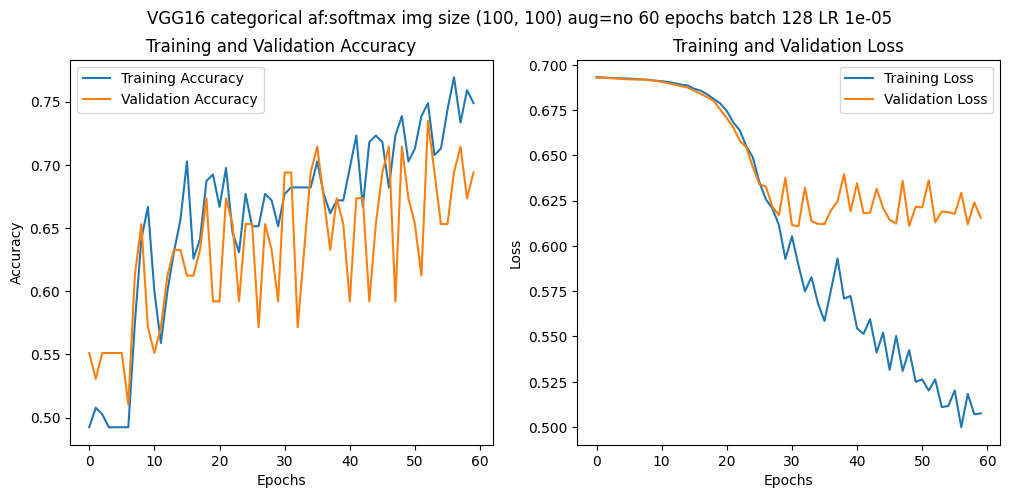

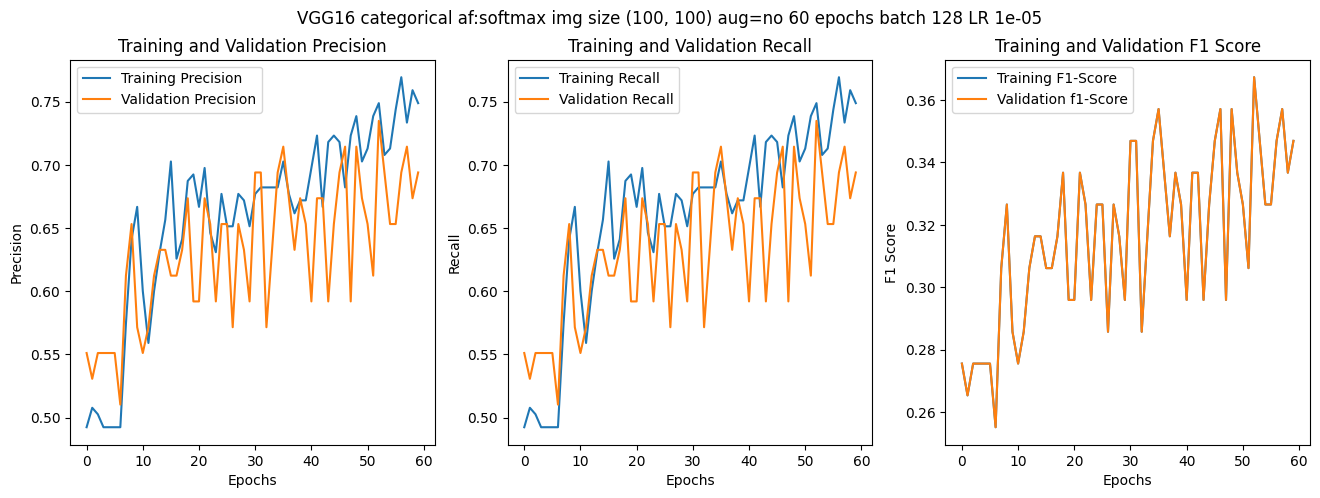

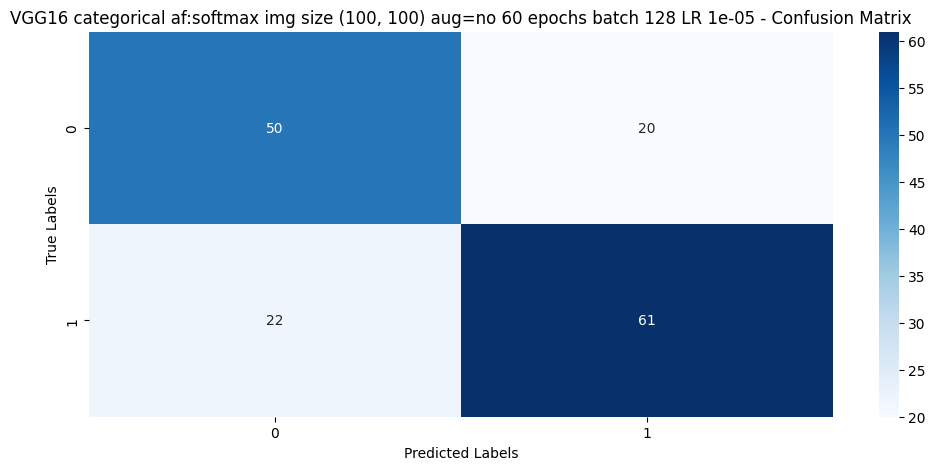

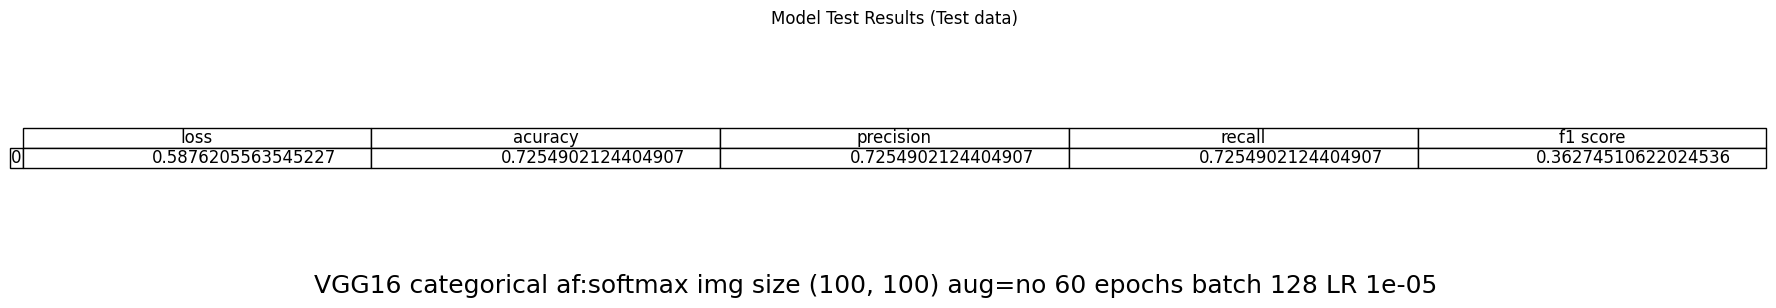

In [ ]:
result = vgg16.evaluate(test_images,  test_labels, batch_size=64, verbose=1)
metrics = vgg16.get_metrics_result()
plot_history(history_vgg16,metrics, title)
if mode == 'binary':
  plot_binary_confusion_matrix(vgg16, test_images, test_labels, threshold, title)
else:
    plot_confusion_matrix(vgg16, test_images, test_labels, title)
plot_table(result,vgg16.metrics_names,title)
